---
title: Downloading Climate Data from ERA5-Land
short_title: ERA5-Land
---

In this notebook we will demonstrate how we can use Climate Tools and `dhis2eo` to retrieve climate data for a set of DHIS2 organisation units, based on the [ERA5-Land dataset](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land), hosted at the [ECMWF Climate Data Store (CDS)](https://cds.climate.copernicus.eu/datasets). 

**Important:** Make sure you have followed [these instructions](api-authentication.md) to authenticate and allow API access the CDS portal. 

--------------------------------------------
## What you need

We start by importing the necessary libraries:

In [1]:
import geopandas as gpd
import xarray as xr

from dhis2eo.data.cds import era5_land

In order to know which geographical area we should download data for, we also load our Sierra Leone organisation unit GeoJSON file downloaded from DHIS2. Alternative, see our [guide for how to fetch organisation units directly from your DHIS2 instance](../../org-units/download-web-api.ipynb). 

In [2]:
org_units = gpd.read_file('../../data/sierra-leone-districts.geojson')
org_units

,type,id,name,hasCoordinatesDown,hasCoordinatesUp,level,grandParentParentGraph,grandParentId,parentGraph,parentId,parentName,dimensions,weight,geometry
0,Polygon,O6uvpzGd5pu,Bo,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,Polygon,fdc6uOvgoji,Bombali,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,MultiPolygon,lc3eMKXaEfw,Bonthe,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,Polygon,jUb8gELQApl,Kailahun,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,MultiPolygon,PMa2VCrupOd,Kambia,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,Polygon,kJq2mPyFEHo,Kenema,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,Polygon,qhqAxPSTUXp,Koinadugu,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Polygon,Vth0fbpFcsO,Kono,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,MultiPolygon,jmIPBj66vD6,Moyamba,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,MultiPolygon,TEQlaapDQoK,Port Loko,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


--------

## Downloading ERA5-Land data

The `dhis2eo.data.cds.era5_land` module allows you to easily download climate data for different time periods from the ERA5-Land dataset. 

### Hourly data

To import daily ERA5-Land data into DHIS2, one might be tempted to use the dataset [ERA5-Land at daily levels](https://cds.climate.copernicus.eu/datasets/derived-era5-land-daily-statistics), but this unfortunately does not include the precipitation variable. Instead, we recommend downloading [ERA5-Land data at hourly levels](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land), and then [aggregating up to the daily level](../../aggregation/time-period-aggregation.ipynb). 

The ERA5-Land hourly data can be requested from the [Climate Data Store](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land) as a single NetCDF file for a given month. To make this more convenient, we can use the `hourly` version of the `dhis2eo.data.cds.era5_land` module which iterates and downloads all monthly files for a given time period. 

#### Parameters

We set the `start` and `end` parameters to only get climate data for the months of July, August, and September of 2025, and set the bounding box (`bbox`) to only get data for the spatial extent of the org units. 

We also specify a `dirname` for where the data should be saved and a `prefix` for naming the downloaded files.

Finally, we specify which climate `variables` we want to download - specifically 2m temperature and total precipitation. For a list of all the available ERA5-Land variables, see the [Dataset Download Page](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=download). 

In [16]:
start = "2025-07"
end = "2025-09"
bbox = org_units.total_bounds
dirname = '../../data/local'
prefix = 'era5_hourly_sierra_leone'
variables = ["2m_temperature", "total_precipitation"]

#### Download to disk

Run the download function which will retrieve the data one month at a time to the location you specified. Downloads can take a few minutes for each month downloaded. The returned list shows the location of the downloaded files: 

In [17]:
files = era5_land.hourly.download(start=start, end=end, bbox=bbox, dirname=dirname, prefix=prefix, variables=variables)
files

INFO - 2026-01-21 22:16:37,147 - dhis2eo.data.cds.era5_land.hourly - Month 2025-7
INFO - 2026-01-21 22:16:37,155 - dhis2eo.data.cds.era5_land.hourly - File already downloaded: C:\Users\karimba\Documents\Github\climate-tools\docs\guides\data\local\era5_hourly_sierra_leone_2025-07.nc
INFO - 2026-01-21 22:16:37,156 - dhis2eo.data.cds.era5_land.hourly - Month 2025-8
INFO - 2026-01-21 22:16:37,159 - dhis2eo.data.cds.era5_land.hourly - File already downloaded: C:\Users\karimba\Documents\Github\climate-tools\docs\guides\data\local\era5_hourly_sierra_leone_2025-08.nc
INFO - 2026-01-21 22:16:37,161 - dhis2eo.data.cds.era5_land.hourly - Month 2025-9
INFO - 2026-01-21 22:16:37,164 - dhis2eo.data.cds.era5_land.hourly - File already downloaded: C:\Users\karimba\Documents\Github\climate-tools\docs\guides\data\local\era5_hourly_sierra_leone_2025-09.nc


[WindowsPath('C:/Users/karimba/Documents/Github/climate-tools/docs/guides/data/local/era5_hourly_sierra_leone_2025-07.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/climate-tools/docs/guides/data/local/era5_hourly_sierra_leone_2025-08.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/climate-tools/docs/guides/data/local/era5_hourly_sierra_leone_2025-09.nc')]

The download function treats the files saved under the given `dirname` and `prefix` as a cache, so it can safely be rerun multiple times without re-downloading. To ignore the cache and fetch fresh data you can set `overwrite=True`.

#### Inspect the data

Now that the files exists on disk, there are many ways we could work with them. For now, let's open the files as a single xarray dataset, by passing them to `xr.open_mfdataset()`:

In [5]:
ds = xr.open_mfdataset(files)

Inspecting the data we see that the xarray dataset contains the data variables `t2m` (2m temperature), and `tp` (total precipitation), and has 2208 hours in the time dimension (or 3 months of hourly data):

In [6]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:     (valid_time: 2208, latitude: 31, longitude: 31)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 18kB 2025-07-01 ... 2025-09-30T23...
  * latitude    (latitude) float64 248B 9.918 9.818 9.718 ... 7.118 7.018 6.917
  * longitude   (longitude) float64 248B -13.3 -13.2 -13.1 ... -10.5 -10.4 -10.3
    expver      (valid_time) <U4 35kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 8MB dask.array<chunksize=(744, 31, 31), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 8MB dask.array<chunksize=(744, 31, 31), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-21T18:39 GRIB to CDM+CF via cfgrib-0.9.1...

When working with ERA5 data you will often also see the coordinate variables `number` and `expver`, which are related to how the data was produced; these are not usually needed and can be dropped:

In [7]:
ds = ds.drop_vars(['number', 'expver'])

Finally, let's check what the precipitation (`tp`) was at 12:00 on August 31:

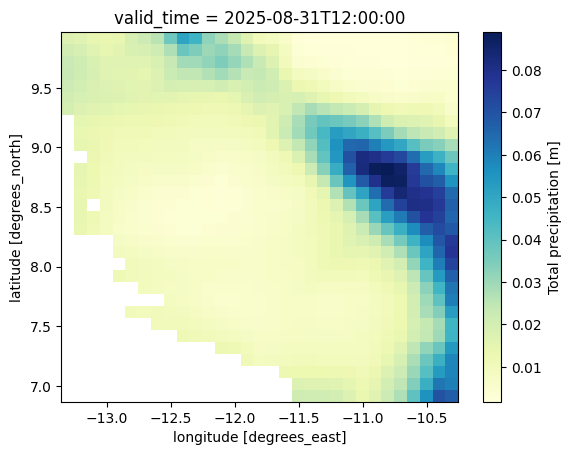

In [8]:
ds.sel(valid_time='2025-08-31T12:00')['tp'].plot(cmap='YlGnBu')

**Important**: Since DHIS2 does not deal directly with hourly data, you will also need to [aggregate from hourly to daily data](../../aggregation/time-period-aggregation.ipynb) before you can import the data to DHIS2. 

### Monthly data

Sometimes you may only be interested in monthly climate data at longer time scales. In these cases, we recommend downloading the [monthly ERA5-Land data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means). 

These data can be downloaded as a single NetCDF file covering multiple years of monthly data, by using the `monthly` version of the `dhis2eo.data.cds.era_land` module. 

#### Parameters

Similarly to the hourly data, we specify the `start` and `end` parameters for the time period 2000 to 2025, `bbox` of our organisation units, download `dirname` and `prefix`, and list of climate `variables`:

In [9]:
start = "2000"
end = "2025"
bbox = org_units.total_bounds
dirname = '../../data/local'
prefix = 'era5_monthly_sierra_leone'
variables = ["2m_temperature", "total_precipitation"]

#### Download to disk

Now we can run the download function which will download monthly climate data as a single NetCDF file:

In [10]:
files = era5_land.monthly.download(start=start, end=end, bbox=bbox, dirname=dirname, prefix=prefix, variables=variables)
files

INFO - 2026-01-21 22:15:26,062 - dhis2eo.data.cds.era5_land.monthly - File already downloaded: C:\Users\karimba\Documents\Github\climate-tools\docs\guides\data\local\era5_monthly_sierra_leone_2000-2025.nc


[WindowsPath('C:/Users/karimba/Documents/Github/climate-tools/docs/guides/data/local/era5_monthly_sierra_leone_2000-2025.nc')]

#### Inspect the data

Since this is only a single file, let's open the downloaded file as a regular xarray dataset, and drop the variables we don't need:

In [11]:
monthly_ds = xr.open_dataset(files[0])
monthly_ds = monthly_ds.drop_vars(['number', 'expver'])

We see the result contains 312 months (about 25 years) of temperature (`t2m`) and precipitation (`tp`) data variables: 

In [12]:
monthly_ds

<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 312, latitude: 31, longitude: 31)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2000-01-01 ... 2025-12-01
  * latitude    (latitude) float64 248B 9.918 9.818 9.718 ... 7.118 7.018 6.917
  * longitude   (longitude) float64 248B -13.3 -13.2 -13.1 ... -10.5 -10.4 -10.3
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1MB ...
    tp          (valid_time, latitude, longitude) float32 1MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-21T18:56 GRIB to CDM+CF via cfgrib-0.9.1...

**Important**: The [monthly version of ERA5-Land](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means) reports all variables as daily averages. For some of the variables such as precipitation, we are instead interested in the **total precipitation** for the entire month. This can be done by multiplying the average daily precipitation (`tp`) with the number of days per month (xarray date fields provide this as an attribute `.dt.days_in_month`): 

In [13]:
total_precip = monthly_ds['tp'] * monthly_ds.valid_time.dt.days_in_month

Let's see what the total precipitation was for the month of August 2025:

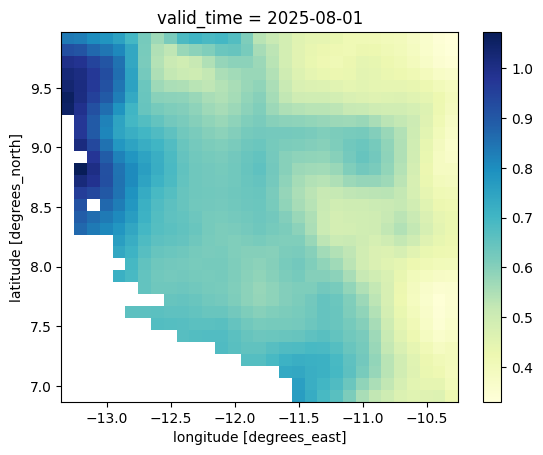

In [14]:
total_precip.sel(valid_time='2025-08').plot(cmap='YlGnBu')

## Next steps

This notebook has showed how to download both hourly and monthly ERA5-Land climate data. For guidance on what to do with the data after downloading, see: 

* [Aggregate the data](../../aggregation/intro.md).
* [Import the aggregated data to DHIS2](../../import-data/intro.md).

If you want to skip to the end, you can also check out [this example workflow](/workflows/import-era5/import-era5-daily) that includes all the steps needed to download and import ERA5-Land data from start to finish. 